### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл)

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.0MB/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.02MB/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.9MB/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [ ]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [ ]:
len(dataloader)

3750

In [ ]:
for image, cat in dataloader:
    break

In [ ]:
image.size()

torch.Size([16, 1, 28, 28])

In [ ]:
28*28

784

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [ ]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label.view(16, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label.view(16, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label.view(16, 1))
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.21 errD_z: 0.19 errG: 1.81
Epoch:1 Iter: 200 errD_x: 0.29 errD_z: 0.09 errG: 2.59
Epoch:1 Iter: 300 errD_x: 0.19 errD_z: 0.17 errG: 2.19
Epoch:1 Iter: 400 errD_x: 0.26 errD_z: 0.13 errG: 2.17
Epoch:1 Iter: 500 errD_x: 0.10 errD_z: 0.07 errG: 2.75
Epoch:1 Iter: 600 errD_x: 0.02 errD_z: 0.08 errG: 2.62
Epoch:1 Iter: 700 errD_x: 0.10 errD_z: 0.08 errG: 2.75
Epoch:1 Iter: 800 errD_x: 0.09 errD_z: 0.26 errG: 1.98
Epoch:1 Iter: 900 errD_x: 0.12 errD_z: 0.19 errG: 1.94
Epoch:1 Iter: 1000 errD_x: 0.13 errD_z: 0.45 errG: 1.33
Epoch:1 Iter: 1100 errD_x: 0.41 errD_z: 0.23 errG: 2.00
Epoch:1 Iter: 1200 errD_x: 0.21 errD_z: 0.25 errG: 1.84
Epoch:1 Iter: 1300 errD_x: 0.24 errD_z: 0.23 errG: 1.75
Epoch:1 Iter: 1400 errD_x: 0.07 errD_z: 0.22 errG: 1.77
Epoch:1 Iter: 1500 errD_x: 0.15 errD_z: 0.18 errG: 2.20
Epoch:1 Iter: 1600 errD_x: 0.06 errD_z: 0.23 errG: 2.31
Epoch:1 Iter: 1700 errD_x: 0.13 errD_z: 0.14 errG: 2.66
Epoch:1 Iter: 1800 errD_x: 0.17 errD_z: 0.15 errG: 2.63
E

KeyboardInterrupt: 

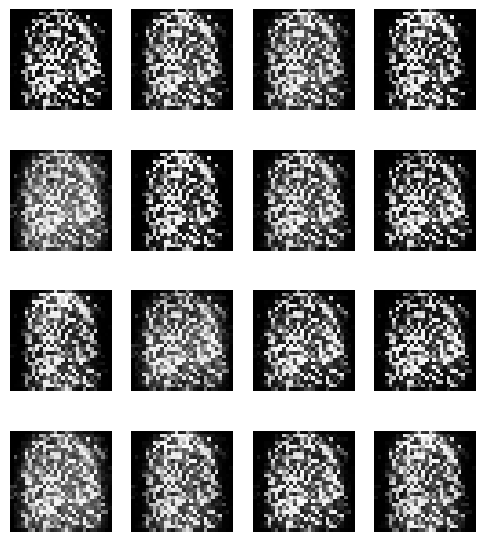

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

___

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Config:
    pass

config = Config()
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 5
config.noise_size = 50
config.clamp_value = 0.01  # для weight clipping
config.critic_iters = 5   # кол-во итераций обучения критика на 1 итерацию генератора
config.lr = 1e-4

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(
    root="fashion_mnist",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

100%|██████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 689kB/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:00<00:00, 14.2MB/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 9.94MB/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [4]:
dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers
)

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_size=50, out_dim=28*28):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, out_dim),
            nn.Tanh()  # Для WGAN можно использовать Tanh или просто оставить ReLU
        )

    def forward(self, z):
        return self.model(z)

In [6]:
class Critic(nn.Module):
    def __init__(self, in_dim=28*28):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)  # Без сигмоиды!
        )

    def forward(self, x):
        return self.model(x)

In [7]:
generator = Generator(config.noise_size).cuda()
critic = Critic().cuda()

In [8]:
optim_G = optim.RMSprop(generator.parameters(), lr=config.lr)
optim_C = optim.RMSprop(critic.parameters(), lr=config.lr)

In [9]:
def train_wgan_weight_clipping():
    G_losses, C_losses = [], []

    for epoch in range(config.num_epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.view(real_imgs.size(0), -1).cuda()

            # ----- ОБУЧАЕМ КРИТИК -----
            for _ in range(config.critic_iters):
                noise = torch.randn(real_imgs.size(0), config.noise_size).cuda()

                fake_imgs = generator(noise).detach()
                
                # Loss Critic = E[C(fake)] - E[C(real)]
                critic_loss = torch.mean(critic(fake_imgs)) - torch.mean(critic(real_imgs))

                optim_C.zero_grad()
                critic_loss.backward()
                optim_C.step()

                # Weight clipping
                for p in critic.parameters():
                    p.data.clamp_(-config.clamp_value, config.clamp_value)
            
            # ----- ОБУЧАЕМ ГЕНЕРАТОР -----
            noise = torch.randn(real_imgs.size(0), config.noise_size).cuda()
            fake_imgs = generator(noise)
            
            # Loss Generator = -E[C(fake)]
            gen_loss = -torch.mean(critic(fake_imgs))

            optim_G.zero_grad()
            gen_loss.backward()
            optim_G.step()

            G_losses.append(gen_loss.item())
            C_losses.append(critic_loss.item())

            if (i + 1) % 100 == 0:
                print(f"[Epoch {epoch+1}/{config.num_epochs}] [Iter {i+1}] "
                      f"C_loss: {critic_loss.item():.4f} G_loss: {gen_loss.item():.4f}")

    return G_losses, C_losses

In [10]:
G_losses_wclip, C_losses_wclip = train_wgan_weight_clipping()


[Epoch 1/5] [Iter 100] C_loss: -0.0185 G_loss: 0.0886
[Epoch 1/5] [Iter 200] C_loss: -0.0356 G_loss: 0.0216
[Epoch 1/5] [Iter 300] C_loss: -0.0703 G_loss: -0.6940
[Epoch 1/5] [Iter 400] C_loss: -0.0555 G_loss: 0.1085
[Epoch 1/5] [Iter 500] C_loss: -0.0804 G_loss: 0.0270
[Epoch 1/5] [Iter 600] C_loss: -0.0774 G_loss: -0.0539
[Epoch 1/5] [Iter 700] C_loss: -0.0499 G_loss: -0.1083
[Epoch 1/5] [Iter 800] C_loss: -0.0460 G_loss: -0.0856
[Epoch 1/5] [Iter 900] C_loss: -0.0645 G_loss: -0.0876
[Epoch 1/5] [Iter 1000] C_loss: -0.0646 G_loss: -0.0481
[Epoch 1/5] [Iter 1100] C_loss: -0.0354 G_loss: -0.0673
[Epoch 1/5] [Iter 1200] C_loss: -0.0822 G_loss: 0.0087
[Epoch 1/5] [Iter 1300] C_loss: -0.0482 G_loss: -0.0238
[Epoch 1/5] [Iter 1400] C_loss: -0.0122 G_loss: 0.0373
[Epoch 1/5] [Iter 1500] C_loss: -0.0300 G_loss: -0.0043
[Epoch 1/5] [Iter 1600] C_loss: -0.0153 G_loss: -0.1053
[Epoch 1/5] [Iter 1700] C_loss: -0.0391 G_loss: -0.0383
[Epoch 1/5] [Iter 1800] C_loss: -0.0388 G_loss: 0.0159
[Epoch 1

In [11]:
def show_generated_images(generator):
    generator.eval()
    noise = torch.randn(16, config.noise_size).cuda()
    with torch.no_grad():
        samples = generator(noise).cpu().view(-1, 1, 28, 28)

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(samples[idx].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    generator.train()

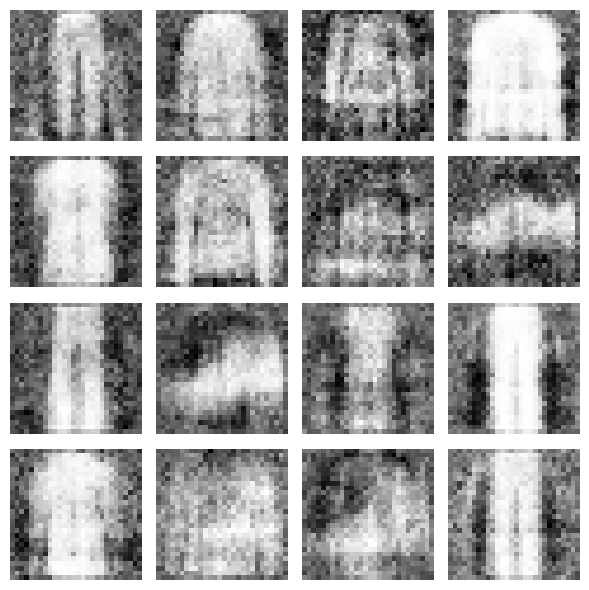

In [12]:
show_generated_images(generator)

###  WGAN с Gradient Penalty (WGAN-GP)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
class CriticWGANGP(nn.Module):
    def __init__(self, in_dim=28*28):
        super(CriticWGANGP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)  # без сигмоиды
        )

    def forward(self, x):
        return self.model(x)

In [15]:
def gradient_penalty(critic, real_samples, fake_samples, device="cuda"):
    alpha = torch.rand(real_samples.size(0), 1).to(device)
    alpha = alpha.expand_as(real_samples).contiguous()  # [batch_size, 784]
    
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates = interpolates.detach().requires_grad_(True)
    
    critic_interpolates = critic(interpolates)
    # По умолчанию (batch, 1) → нужно получить градиенты wrt interpolates
    grad_outputs = torch.ones_like(critic_interpolates).to(device)

    # Вычисляем градиент
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # penalty = E[ (||grad||2 - 1)^2 ]
    gradients = gradients.view(gradients.size(0), -1)
    penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return penalty


In [16]:
lambda_gp = 10.0

critic = CriticWGANGP().cuda()
optim_C = optim.Adam(critic.parameters(), lr=config.lr, betas=(0.5, 0.9))
optim_G = optim.Adam(generator.parameters(), lr=config.lr, betas=(0.5, 0.9))

In [17]:
for epoch in range(config.num_epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.view(real_imgs.size(0), -1).cuda()

        # ----- ОБУЧАЕМ КРИТИК -----
        for _ in range(config.critic_iters):
            noise = torch.randn(real_imgs.size(0), config.noise_size).cuda()
            fake_imgs = generator(noise).detach()

            # critic_loss = E[C(fake)] - E[C(real)] + lambda_gp * gradient_penalty
            critic_loss = (torch.mean(critic(fake_imgs)) - torch.mean(critic(real_imgs)))

            # добавляем gradient penalty
            gp = gradient_penalty(critic, real_imgs, fake_imgs)
            critic_loss += lambda_gp * gp

            optim_C.zero_grad()
            critic_loss.backward()
            optim_C.step()

        # ----- ОБУЧАЕМ ГЕНЕРАТОР -----
        noise = torch.randn(real_imgs.size(0), config.noise_size).cuda()
        fake_imgs = generator(noise)
        gen_loss = -torch.mean(critic(fake_imgs))

        optim_G.zero_grad()
        gen_loss.backward()
        optim_G.step()

### Условный WGAN (Conditional WGAN)

In [18]:
num_classes = 10

In [19]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_size=50, num_classes=10, out_dim=784):
        super(ConditionalGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_size + num_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, out_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels_onehot):
        x = torch.cat([noise, labels_onehot], dim=1)
        out = self.model(x)
        return out

In [20]:
class ConditionalCritic(nn.Module):
    def __init__(self, in_dim=784, num_classes=10):
        super(ConditionalCritic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim + num_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1)  # без сигмоиды
        )

    def forward(self, imgs, labels_onehot):
        x = torch.cat([imgs, labels_onehot], dim=1)
        return self.model(x)

In [21]:
generator_cond = ConditionalGenerator().cuda()
critic_cond = ConditionalCritic().cuda()

### выводы

WGAN с weight clipping (заменили функцию потерь на Wasserstein, после каждого шага оптимизации дискриминатора делали weight clipping, обучали дискриминатор большее число итераций на каждую итерацию генератора)

WGAN-GP (убрали clipping, добавили расчет gradient penalty на линейных интерполяциях между реальными и фейковыми сэмплами, штраф прибавляли к функции потерь дискриминатора)

Conditional WGAN (добавили вектор one-hot метки к входам генератора и критика)

для улучшения можно

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


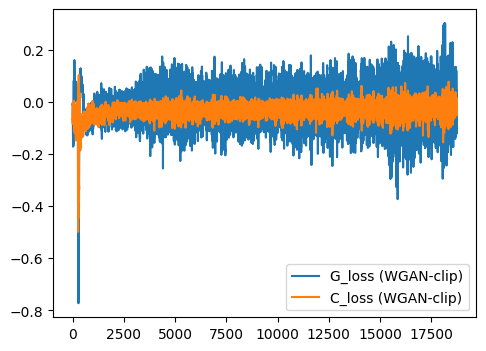

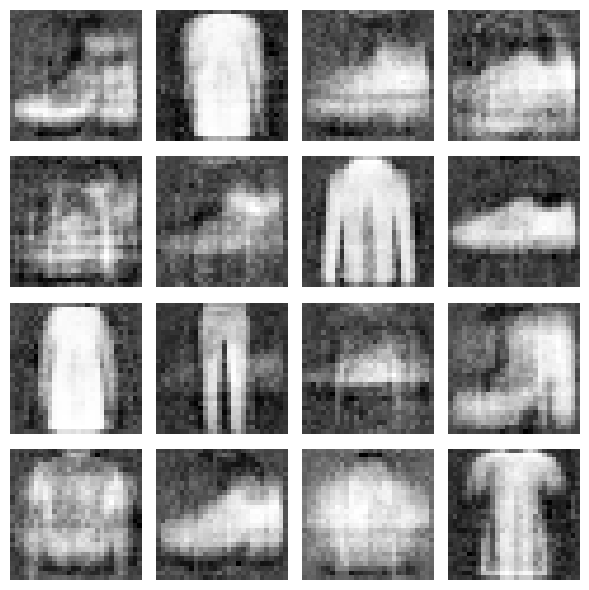

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(G_losses_wclip, label='G_loss (WGAN-clip)')
plt.plot(C_losses_wclip, label='C_loss (WGAN-clip)')
plt.legend()

# Пример сэмплов
show_generated_images(generator)
